# Initialise Notebook

In [ ]:
from os import getcwd, pardir
from os.path import join, abspath

! jupyter nbextension enable --py --sys-prefix widgetsnbextension

## Get Root Directory
rootDirectory = abspath(join(abspath(join(getcwd(), pardir)), pardir))

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')

## Create a button that hides cells
from IPython.display import HTML

HTML(
    '''
    <script>
    code_show=true; 
    function code_toggle() {
        if (code_show){
            $('div.input').show();
        } else {
            $('div.input').hide();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

%load_ext autoreload
%autoreload 2

# Load Device Data

In [1]:
from api_utils import *
import re

def getDeviceDataInteractive(b):
    clear_output()
    frequency = frequency_text.value + frequency_drop.value
    devices = kitList.value.strip('').split(',')
    devicesCorrected = list()
    for device in devices: 
        device = re.sub(' ', '', device)
        devicesCorrected.append(device)
    test_name = testName.value
    # print devicesCorrected
    print 'Downloading with frequency', frequency
    print 'Data Range from', start_date_widget.value, 'to', end_date_widget.value
    if test_name != '':
        try:
            readings[test_name] = dict()
            
            readings[test_name] = getReadingsAPI(devicesCorrected, frequency, start_date_widget.value, end_date_widget.value)
        except NameError:
            global readings
            readings = dict()
            readings[test_name] = getReadingsAPI(devicesCorrected, frequency, start_date_widget.value, end_date_widget.value)
    else:
        print 'Input test '

def getKitIDInteractive(b):
    clear_output()
    devices = kitList.value.strip('').split(',')
    kitIDs = list()
    for device in devices:
        kitID = getKitID(device, False)
        kitIDs.append(kitID)
        print('Device {} has kitID {}'.format(device, kitID))
    return kitIDs

kitList = widgets.Text(description = 'Kit List: ')
testName = widgets.Text(description = 'Input Test Name')

getKitIDb = widgets.Button(description='Get Kit ID')
getKitIDb.on_click(getKitIDInteractive)

loadAPIb = widgets.Button(description='Load API Kit')
loadAPIb.on_click(getDeviceDataInteractive)

frequency_text = widgets.Text(description = 'Frequency',
                              value = '1',
                              layout = widgets.Layout(width='300px'))
frequency_drop = widgets.Dropdown(options = ['H', 'Min', 'S'],
                                  value = 'Min',
                                  description = '',
                                  layout = widgets.Layout(width='50px'))

start_date_widget = widgets.DatePicker(description='Start Date')
end_date_widget = widgets.DatePicker(description='End Date')
dateBox = widgets.HBox([start_date_widget, end_date_widget])

frequency_box = widgets.HBox([frequency_text, frequency_drop])

Hbox = widgets.HBox([kitList, testName])
ButtonBox = widgets.HBox([getKitIDb, loadAPIb])
Box = widgets.VBox([Hbox, frequency_box, dateBox, ButtonBox])

display(Box)

Data Range from 2018-11-26 00:00:00 to 2018-12-04 00:00:00
Loading device 5104
Kit ID 20
	From Date 2018-11-26 00:00:00 to Date 2018-12-04 00:00:00
	Device located in Europe/Helsinki
	Done


# Functions

In [9]:
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plot
from xgboost import XGBRegressor 

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def plotModelResults(X, y, index, prediction, name, lower, upper, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    """

    plot.figure(figsize=(15, 7))
    plot.plot(index, prediction, "g", label="Prediction", linewidth=2.0)
    plot.plot(index, y, label="actual", linewidth=2.0)
    
    if plot_intervals:
        
        plot.plot(index, lower, "r--", label="Upper bond / Lower bond", alpha=0.5)
        plot.plot(index, upper, "r--", alpha=0.5)
        
    if plot_anomalies:
        anomaly_values = np.array([np.NaN]*len(y))
        anomaly_values[y<lower] = y[y<lower]
        anomaly_values[y>upper] = y[y>upper]
        plot.plot(index, anomaly_values, "o", markersize=5, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y)
    plot.title(name + ": Mean absolute percentage error {0:.2f}%".format(error))
    plot.legend(loc="best")
    plot.tight_layout()
    plot.grid(True);
    plot.show()
    

def prepareDataFrame(_data, _frequencyResample, _irrelevantColumns, _plotModelAnom = True, _scaleAnom = 1.9, _methodAnom = 'before-after-avg'):
    '''
        Function for Dataframe preparation: resampling and anomalies cleaning
        data: Pandas dataframe with datetime index
        frequency: target datetime index frequency to resample to
        irrelevant_columns: ignore columns for anomaly detection (tipically BATT, BATT_CHG_RATE and LIGHT)
        plotModelAnom: plot anomaly model
        scaleAnom: range for anomaly detection thresholds (between 1 and 3)
        methodAnom = anomaly treatment method
    '''

    def prepareForAnomalies(series, lag_start, lag_end, test_size, target_encoding=False):
        """
            series: pd.DataFrame
                dataframe with timeseries
            lag_start: int
                initial step back in time to slice target variable 
                example - lag_start = 1 means that the model 
                          will see yesterday's values to predict today
            lag_end: int
                final step back in time to slice target variable
                example - lag_end = 4 means that the model 
                          will see up to 4 days back in time to predict today
            test_size: float
                size of the test dataset after train/test split as percentage of dataset
            target_encoding: boolean
                if True - add target averages to the dataset
            
        """
        
        # copy of the initial dataset
        data = pd.DataFrame(series.copy())
        data.columns = ["y"]
        
        # lags of series
        for i in range(lag_start, lag_end):
            data["lag_{}".format(i)] = data.y.shift(i)
        
        # datetime features
        # data.index = data.index.to_datetime()
        data["hour"] = data.index.hour
        data["weekday"] = data.index.weekday
        data['is_weekend'] = data.weekday.isin([5,6])*1
        
        if target_encoding:
            # calculate averages on train set only
            test_index = int(len(data.dropna())*(1-test_size))
            data['weekday_average'] = list(map(
                code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
            data["hour_average"] = list(map(
                code_mean(data[:test_index], 'hour', "y").get, data.hour))

            # frop encoded variables 
            data.drop(["hour", "weekday"], axis=1, inplace=True)
        
        # train-test split
        y = data.dropna().y
        X = data.dropna().drop(['y'], axis=1)
        index = X.index
        X_train, X_test, y_train, y_test =\
            timeseries_train_test_split(X, y, test_size=test_size)

        return X_train, X_test, y_train, y_test, index

    def calculateAnomalies(_data, _frecuency = '1Min' , _scale = 2, _plotModel = False):
        name = _data.name
        scaler = StandardScaler()
        tscv = TimeSeriesSplit(n_splits=5)
        
        # Extract frequency and convert it to lags
        offset = pd.tseries.frequencies.to_offset(_frecuency)
        alias = pd.tseries.frequencies.get_base_alias(_frecuency)
        
        LUT_CONVERT_FREQ = (['Min', 1], 
                       ['S', 1/60], 
                       ['H', 60])
        
        factor = 0
        for item in LUT_CONVERT_FREQ:
            if item[0] == alias:
                factor = item[1]*offset.n
        
        # good lag for 1Min frequency seems to be 60 for all signals
        lag_end = max(10, 60/factor)
        
        X, _, y, _, index =\
            prepareForAnomalies(_data, lag_start=3, lag_end = lag_end, test_size=0, target_encoding=False)

        anomalies = np.zeros(len(y))
        
        if (len(y)):
            print 'Calculating', name

            X_scaled = scaler.fit_transform(X)
             
            xgb = XGBRegressor()
            model = xgb.fit(X_scaled, y)
            
            prediction = model.predict(X_scaled)
            
            cv = cross_val_score(model, X_scaled, y,
                                cv = tscv, 
                                scoring = "neg_mean_squared_error")
            
            deviation = np.sqrt(cv.std())
            
            lower = prediction - (_scale * deviation)
            upper = prediction + (_scale * deviation)
                    
            anomalies[y<lower] = 1
            anomalies[y>upper] = 1
            
            if _plotModel: 
                plotModelResults(X, y, index, prediction, name,
                                 lower, upper, 
                                 True, True)
                
        series = pd.Series(anomalies)
        series.index = index
        
        return series
    
    def cleanAnomalies(dataframe, column, method):
        '''
            Function to clean dataframe, provided a column with anomalies and a marker
            column, with ones where the anomalies are found.
            Method can be selected among:
                - before-after-avg: averages the prior and posterior element of the anomaly
                - fill-...:
                    - zeroes: inputs a 0 in the anomaly
                    - nan: inputs a nan in the anomaly
                    - avg: 
        '''
        list_anom = list(np.where(dataframe[column + append_anomalies] == 1)[0])
        clean_column = dataframe[column]
        print 'Cleaning', column
        
        if method == 'before-after-avg':
            for item in list_anom:
                if item < len(clean_column)-1:
                    clean_column[item] = (clean_column[item - 1]\
                                + clean_column[item + 1])/2
        elif method == 'fill-zeroes':
            for item in list_anom:
                clean_column[item] = 0
        elif method == 'fill-nan':
            for item in list_anom:
                clean_column[item] = np.nan
        elif method == 'fill-avg':
            average = np.mean(clean_column)
            for item in list_anom:
                clean_column[item] = average 
        elif method == 'fill-median':
            median = np.median(clean_column)
            for item in list_anom:
                clean_column[item] = median    
        
        return clean_column

    append_anomalies = '_ANOM'
    append_clean = '_CLEAN'
    
    dataFrame = _data.copy()
    dataFrame = _data.resample(_frequencyResample).bfill()
    
    ## Calculate anomalies for each column and treat them
    for column in dataFrame.columns:
        if append_anomalies not in column:
            if column not in _irrelevantColumns:
                dataFrame[column + append_anomalies] = calculateAnomalies(dataFrame[column],
                                                                    _frequencyResample, 
                                                                    _scale = _scaleAnom, 
                                                                    _plotModel = _plotModelAnom)
                
                dataFrame[column + append_clean] = cleanAnomalies(dataFrame.loc[:,[column, column + append_anomalies]],
                                                    column, method = _methodAnom)
            else:
                print 'Ignoring', column
        print '--'
        
    return dataFrame

# Process

Ignoring BATT
--
Calculating HUM


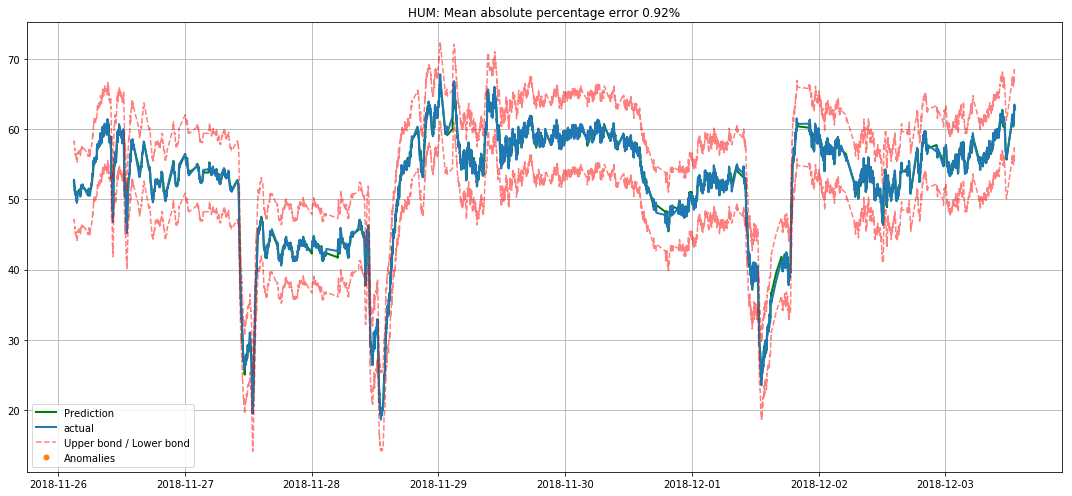

Cleaning HUM
--
Ignoring LIGHT
--
Calculating NOISE_A


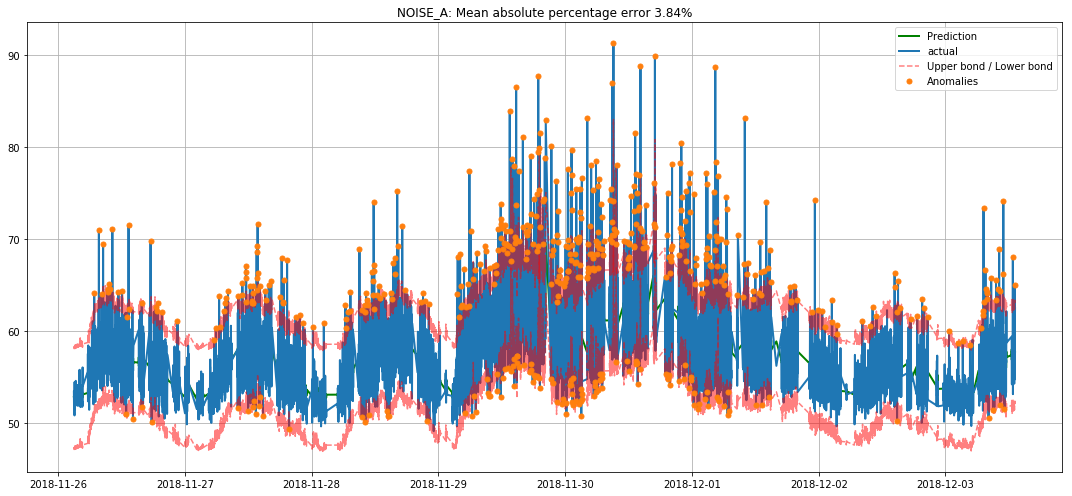

Cleaning NOISE_A
--
Calculating PM_1


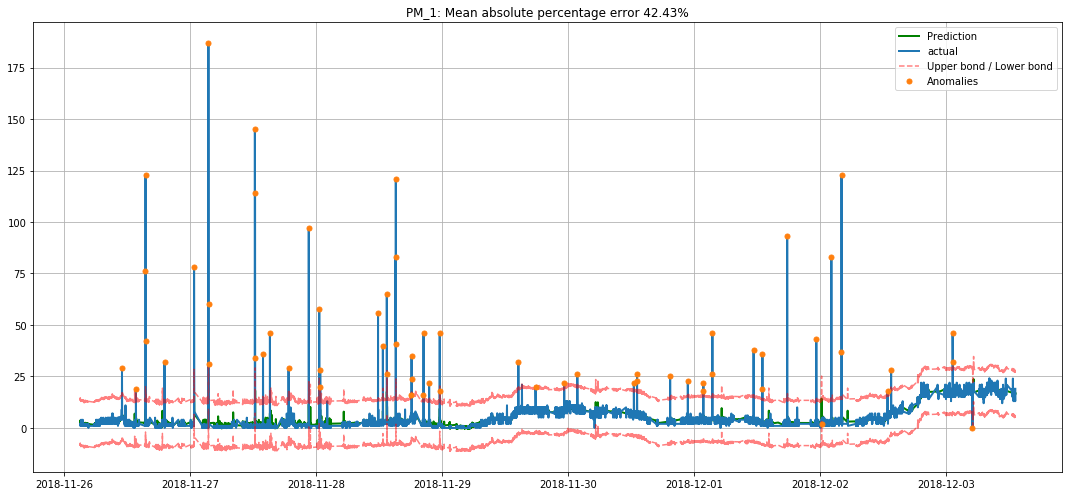

Cleaning PM_1
--
Calculating PM_10


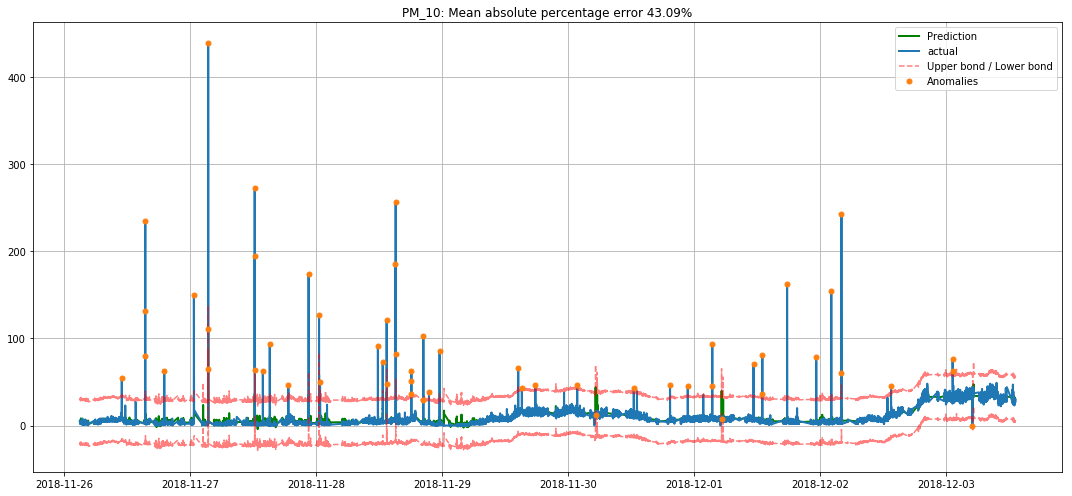

Cleaning PM_10
--
Calculating PM_25


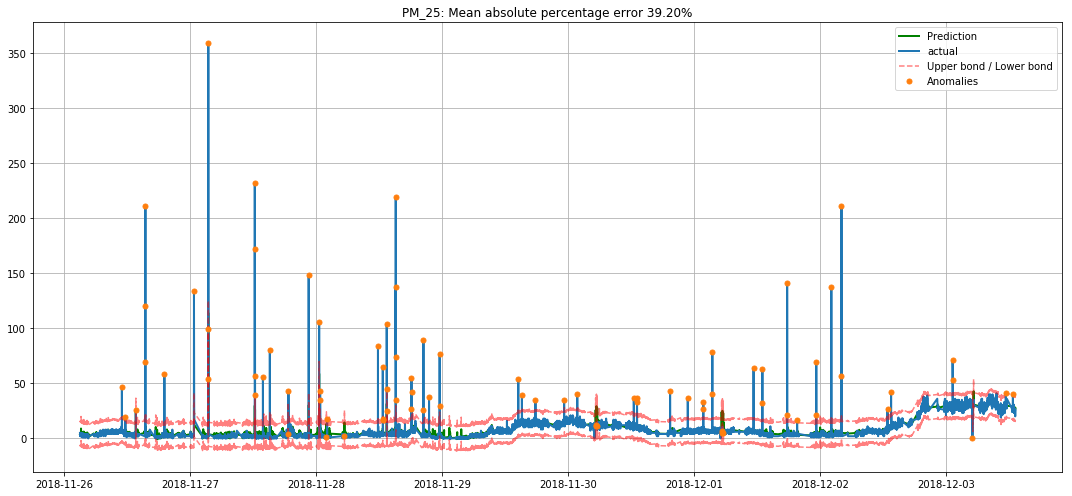

Cleaning PM_25
--
Calculating PRESS


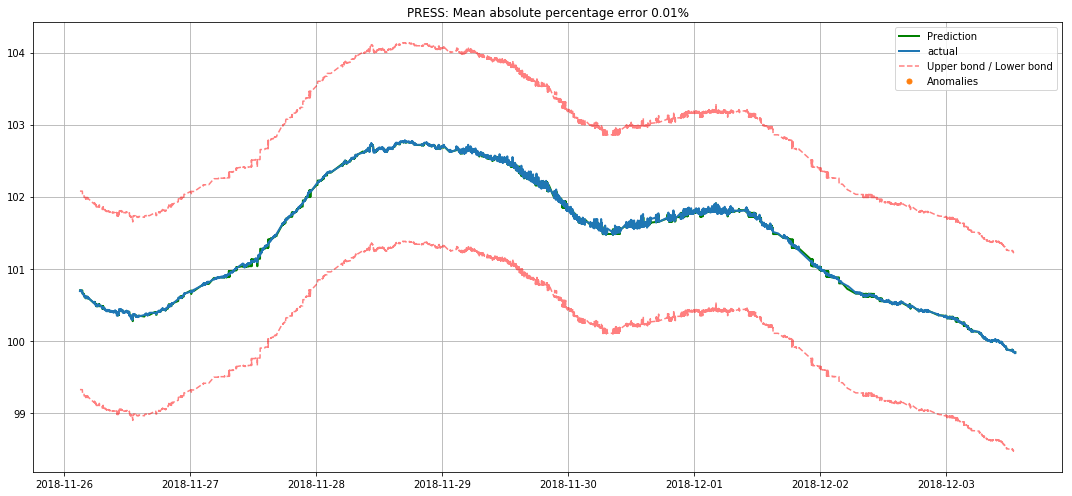

Cleaning PRESS
--
Calculating TEMP


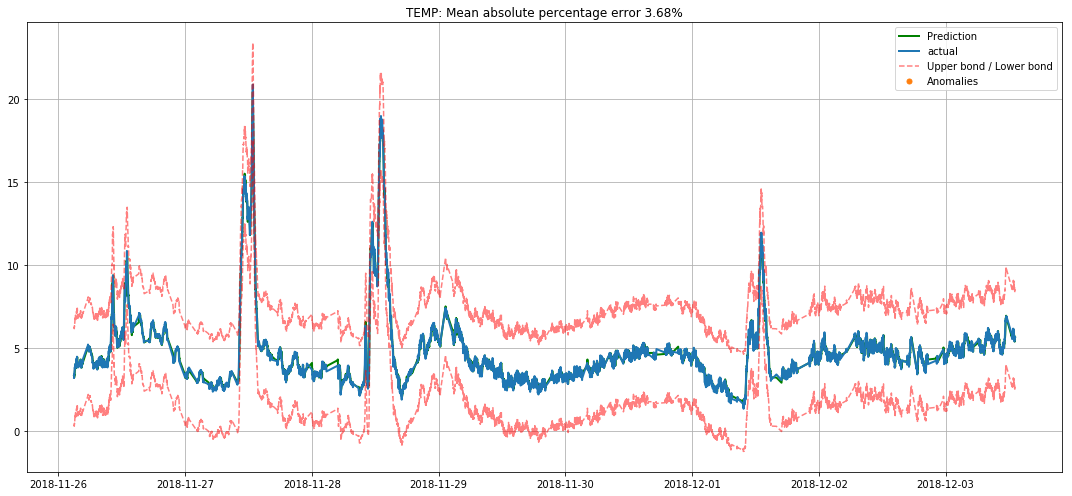

Cleaning TEMP
--


In [10]:
test_name = 'EXAMPLE'
device_name = '5104'
frequency = '1Min' # Resample it to 10Min frequency

## Ignore columns
ignoreColumns = ['BATT', 'BATT_CHG_RATE', 'LIGHT', 'CO_MICS_THEAT', 'NO2_MICS_THEAT']

# Resample data
data = prepareDataFrame(readings[test_name]['devices'][device_name]['data'], 
                 frequency, ignoreColumns, _plotModelAnom = True, 
                 _scaleAnom = 1.9, _methodAnom = 'fill-avg')

# Make a copy to a 'CLEAN' keyword
readings[test_name]['devices'][device_name + '_CLEAN'] = dict()

# Put everything except data inside
for key in readings[test_name]['devices'][device_name].keys():
    if 'data' not in key:
        readings[test_name]['devices'][device_name + '_CLEAN'][key] = readings[test_name]['devices'][device_name][key]

# Put data inside
readings[test_name]['devices'][device_name + '_CLEAN']['data'] = data

-------------------------------------
 Medias:

 5104_CLEAN	NOISE_A	57.07
 5104_CLEAN	NOISE_A_CLEAN	56.64
 5104_CLEAN	PM_25	8.57
 5104_CLEAN	PM_25_CLEAN	8.15
-------------------------------------
-------------------------------------
 Std Deviation:

 5104_CLEAN	NOISE_A	4.51
 5104_CLEAN	NOISE_A_CLEAN	3.64
 5104_CLEAN	PM_25	12.92
 5104_CLEAN	PM_25_CLEAN	10.75
-------------------------------------


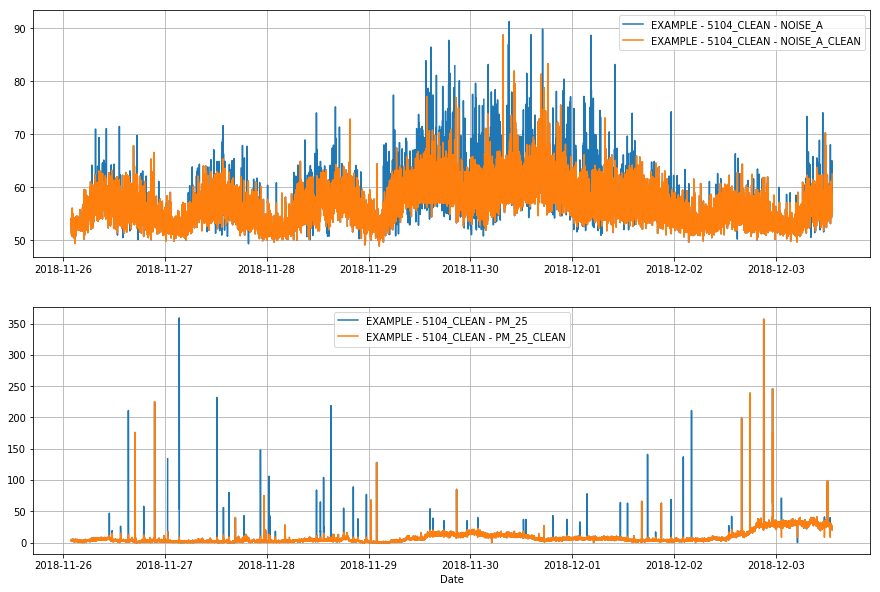

In [11]:
from IPython.display import display, Markdown, FileLink, FileLinks, clear_output, HTML
from IPython.core.display import HTML
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# --
# Plotly
import plotly as ply
import plotly.graph_objs as go
from plotly.widgets import GraphWidget
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls

import matplotlib.pyplot as plot

init_notebook_mode(connected=True)

# Plot Y limits
setLimits = False
maxY = 15000
minY = 0

toshow = []
axisshow = []
# meanTable = []

def show_devices(Source):
    _device.options = [s for s in list(readings[Source]['devices'].keys())]
    _device.source = Source
    #_min_date.value = readings[Source].index.min()._short_repr
    #_max_date.value = readings[Source].index.max()._short_repr

def show_sensors(Source):
    _sensor_drop.options = [s for s in list(readings[_test.value]['devices'][Source]['data'].columns)]
    _sensor_drop.source = Source
    _min_date.value = readings[_test.value]['devices'][Source]['data'].index.min()._short_repr
    _max_date.value = readings[_test.value]['devices'][Source]['data'].index.max()._short_repr

def clear_all(b):
    clear_output()
    del toshow[:]
    del axisshow[:]

def add_sensor(b):
    clear_output()
    d = [_device.source, _sensor_drop.source, _sensor_drop.value]
    
    if d not in toshow: 
        toshow.append(d)
        axisshow.append(_axis_drop.value)
        
    plot_data = readings[toshow[0][0]]['devices'][toshow[0][1]]['data'].loc[:,(toshow[0][2],)]
    list_data_primary = []
    list_data_secondary = []
    list_data_terciary = []
    
    if b.slice_time:
        plot_data = plot_data[plot_data.index > _min_date.value]
        plot_data = plot_data[plot_data.index < _max_date.value]
    
    if len(toshow) > 1:
        for i in range(1, len(toshow)):
            plot_data = pd.merge(plot_data, readings[toshow[i][0]]['devices'][toshow[i][1]]['data'].loc[:,(toshow[i][2],)], left_index=True, right_index=True)
    # plot_data = plot_data.groupby(pd.Grouper(freq='10Min')).aggregate(np.mean)    

    print ('-------------------------------------')
    print (' Medias:\n')
    meanTable = []
    for d in toshow:
        myMean = ' ' + d[1]  + "\t" + d[2] + "\t"
        meanTable.append(myMean)   
    res = plot_data.mean()
    for i in range(len(meanTable)): print (meanTable[i] + '%.2f' % (res[i]))
    print ('-------------------------------------')
    
    print ('-------------------------------------')
    print (' Std Deviation:\n')
    stdTable = []
    for d in toshow:
        myStd = ' ' + d[1]  + "\t" + d[2] + "\t"
        stdTable.append(myStd)   
    std = plot_data.std()
    for i in range(len(stdTable)): print stdTable[i] + '%.2f' % (std[i])
    print ('-------------------------------------')

    # Change columns naming
    changed = []
    for i in range(len(plot_data.columns)):
        changed.append(toshow[i][0] + ' - '+ toshow[i][1] + ' - '+ plot_data.columns[i])
    plot_data.columns = changed
    
    subplot_rows = 0
    if len(toshow) > 0:
        for i in range(len(toshow)):
            if axisshow[i]=='1': 
                list_data_primary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,1)
            if axisshow[i]=='2': 
                list_data_secondary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,2)
            if axisshow[i]=='3': 
                list_data_terciary.append(str(changed[i]))
                subplot_rows = max(subplot_rows,3)
          
    
    if _matplotly.value == 'Plotly':
        fig1 = tls.make_subplots(rows=subplot_rows, cols=1, shared_xaxes=_synchroniseXaxis.value)
    
        #if len(list_data_primary)>0:
            #fig1 = plot_data.iplot(kind='scatter', y = list_data_primary, asFigure=True, layout = layout)
        #ply.offline.iplot(fig1)
        
        for i in range(len(list_data_primary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_primary[i]], 'type': 'scatter', 'name': list_data_primary[i]}, 1, 1)
    
        for i in range(len(list_data_secondary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_secondary[i]], 'type': 'scatter', 'name': list_data_secondary[i]}, 2, 1)
        
        for i in range(len(list_data_terciary)):
            fig1.append_trace({'x': plot_data.index, 'y': plot_data[list_data_terciary[i]], 'type': 'scatter', 'name': list_data_terciary[i]}, 3, 1)
    
        if setLimits: 
            fig1['layout'].update(height = 800,
                                legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                              
        else:
            fig1['layout'].update(height = 800,
                                  legend=dict(x=-.1, y=1.2) ,
                               xaxis=dict(title='Time'))
                               
        ply.offline.plot(fig1)
        
    elif _matplotly.value == 'Matplotlib':
        
        fig, axes = plot.subplots(subplot_rows, 1, figsize=(15,10))
        # Four axes, returned as a 2-d array
        
        if subplot_rows == 1:
            for i in range(len(list_data_primary)):
                axes.plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes.legend(loc='best')

        else:
            for i in range(len(list_data_primary)):
                axes[0].plot(plot_data.index, plot_data[list_data_primary[i]], label =  list_data_primary[i])
                axes[0].legend(loc='best')
                axes[0].grid(visible = True)

            for i in range(len(list_data_secondary)):
                axes[1].plot(plot_data.index, plot_data[list_data_secondary[i]], label =  list_data_secondary[i])
                axes[1].legend(loc='best')
                axes[1].grid(visible = True)

            for i in range(len(list_data_terciary)):
                axes[2].plot(plot_data.index, plot_data[list_data_terciary[i]], label =  list_data_terciary[i])
                axes[2].legend(loc='best')
                axes[2].grid(visible = True)

        plot.xlabel('Date') 
        plot.grid(visible = True)
        plot.show()
        
    
def reset_time(b):
    _min_date.value = readings[b.src.value].index.min()._short_repr
    _max_date.value = readings[b.src.value].index.max()._short_repr

layout=widgets.Layout(width='330px')

# Test dropdown
_test = widgets.Dropdown(options=[k for k in readings.keys()], 
                        layout=layout,
                        description = 'Test')

_test_drop = widgets.interactive(show_devices, 
                                Source=_test, 
                                layout=layout)

# Device dropdown
_device = widgets.Dropdown(layout=layout,
                        description = 'Device')

_device_drop = widgets.interactive(show_sensors, 
                                Source=_device, 
                                layout=layout)

# Sensor dropdown
_sensor_drop = widgets.Dropdown(layout=layout,
                               description = 'Channel')

# Buttons
_b_add = widgets.Button(description='Add to Plot', layout=widgets.Layout(width='120px'))
_b_add.on_click(add_sensor)
_b_add.slice_time = False
_b_reset_all = widgets.Button(description='Clear all', layout=widgets.Layout(width='120px'))
_b_reset_all.on_click(clear_all)

# Axis dropdown
_axis_drop = widgets.Dropdown(
    options=['1', '2', '3'],
    value='1',
    description='Subplot:',
    disabled=False,
)

# Synchronise Checkbox
_synchroniseXaxis = widgets.Checkbox(value=False, 
                                     description='Synchronise X axis', 
                                     disabled=False, 
                                     layout=widgets.Layout(width='300px'))

_matplotly = widgets.RadioButtons(
    options=['Matplotlib', 'Plotly'], value='Matplotlib',
    description='Plot Type',
    disabled=False
)

# Date fields
_min_date = widgets.Text(description='Start date:', 
                         layout=widgets.Layout(width='330px'))
_max_date = widgets.Text(description='End date:', 
                         layout=widgets.Layout(width='330px'))

# Date buttons
_b_apply_time = _b_reset = widgets.Button(description='Apply dates', layout=widgets.Layout(width='100px'))
_b_apply_time.on_click(add_sensor)
_b_apply_time.slice_time = True
_b_reset_time = _b_reset = widgets.Button(description='Reset dates', layout=widgets.Layout(width='100px'))
_b_reset_time.on_click(reset_time)
#_b_reset_time.src = _kit


_device_box = widgets.HBox([_test_drop, _device_drop])
_sensor_box = widgets.HBox([_sensor_drop, _axis_drop, _synchroniseXaxis])
_plot_type_box = widgets.VBox([_matplotly])

_plot_box = widgets.HBox([_b_add , _b_reset_all])
_time_box = widgets.HBox([_min_date,_max_date, _b_reset_time, _b_apply_time])
_root_box = widgets.VBox([_matplotly, _time_box, _device_box, _sensor_box, _plot_box])
display(_root_box)